In [2]:
# --- Jupyter Starter Pack ---

# autoreload: refresh code on every cell run
%reload_ext autoreload
%autoreload 2

# clean warnings
import warnings
warnings.filterwarnings("ignore")

# numpy / pandas nicer display
import numpy as np
np.set_printoptions(precision=4, suppress=True)

# matplotlib defaults
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# tqdm in notebooks
from tqdm.notebook import tqdm

# optional: make exceptions show only the important frame
%config InlineBackend.figure_format = "retina"

import torch, gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchsde

In [12]:
# PARAMETERS
BATCH_SIZE = 16
STEPS = 100        # torchsde is more accurate, so we can often use fewer steps
T_HORIZON = 1.0
LAMBDA_REG = 0.05

In [13]:
class ControlNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x, t):
        # Ensure t is broadcast to the batch size
        t_vec = t.expand(x.shape[0], 1)
        xt = torch.cat([x, t_vec], dim=1)
        return self.net(xt)

In [14]:
class ControlledSDE(nn.Module):
    def __init__(self, ctrl1, ctrl2):
        super().__init__()
        self.ctrl1 = ctrl1
        self.ctrl2 = ctrl2
        self.noise_type = 'diagonal'
        self.sde_type = 'ito'
        
    # Drift function: f(t, y)
    def f(self, t, y):
        # y shape: [BATCH_SIZE, 5] 
        # (x1_a, x1_b, x2_a, x2_b, running_cost)
        
        # Split state
        x1 = y[:, 0:2]
        x2 = y[:, 2:4]
        
        # Prior Drift (Ornstein-Uhlenbeck: -x)
        drift_x1 = -1.0 * x1
        drift_x2 = -1.0 * x2
        
        # Control Force
        u1 = self.ctrl1(x1, t)
        u2 = self.ctrl2(x2, t)
        
        # Total Dynamics = Prior + Control
        dx1 = drift_x1 + u1
        dx2 = drift_x2 + u2
        
        # Running Cost Derivative: d(Cost)/dt = lambda * (|u1|^2 + |u2|^2)
        # We calculate it here so the solver integrates it over time
        # This removes the need to manually sum costs in a loop
        d_cost = torch.sum(u1**2 + u2**2, dim=1, keepdim=True) * LAMBDA_REG
        
        return torch.cat([dx1, dx2, d_cost], dim=1)
    
    # Diffusion function: g(t, y)
    def g(self, t, y):
        # Constant noise for positions (sigma=1), zero noise for cost
        batch_size = y.size(0)
        
        # Noise for x1 (2 dims), x2 (2 dims) -> 1.0
        # Noise for cost (1 dim) -> 0.0
        # We assume diagonal noise for simplicity here
        diffusion_pos = torch.ones(batch_size, 4).to(y.device)
        diffusion_cost = torch.zeros(batch_size, 1).to(y.device)
        
        return torch.cat([diffusion_pos, diffusion_cost], dim=1)

In [15]:

# INITIALIZATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ctrl1 = ControlNet2D().to(device)
ctrl2 = ControlNet2D().to(device)
sde = ControlledSDE(ctrl1, ctrl2).to(device)

optimizer = optim.Adam(list(ctrl1.parameters()) + list(ctrl2.parameters()), lr=0.01)

print(f"Training on {device} using Adjoint Method...")

# TRAINING LOOP
loss_history = []
ITERS = 100

# Time span for solver
ts = torch.linspace(0, T_HORIZON, STEPS).to(device)

for epoch in range(ITERS):
    optimizer.zero_grad()
    
    # 1. Initial State
    # Combine x1, x2 and initial cost (0.0) into one vector
    x1_0 = torch.randn(BATCH_SIZE, 2).to(device)
    x2_0 = torch.randn(BATCH_SIZE, 2).to(device)
    cost_0 = torch.zeros(BATCH_SIZE, 1).to(device)
    
    y0 = torch.cat([x1_0, x2_0, cost_0], dim=1)
    
    # 2. Forward Simulation via Adjoint SDE Solver
    ys = torchsde.sdeint_adjoint(sde, y0, ts, method='srk', dt=1.0/STEPS)
    
    # ys shape: [STEPS, BATCH, 5]
    # We only care about the final state
    y_final = ys[-1]
    
    x1_final = y_final[:, 0:2]
    x2_final = y_final[:, 2:4]
    total_control_cost = torch.mean(y_final[:, 4]) # The integrated cost
    
    # 3. Terminal Loss (Geometric Constraint)
    dist = torch.norm(x1_final - x2_final, p=2, dim=1)
    target_dist = 4.0
    geo_loss = torch.mean((dist - target_dist)**2)
    
    # Total Loss
    loss = geo_loss + total_control_cost
    
    # 4. Backward (handled internally by sdeint_adjoint)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f} (Geo: {geo_loss.item():.4f}, Ctrl: {total_control_cost.item():.4f})")

print("--- Training Complete ---")

Training on cuda using Adjoint Method...
Epoch 0: Loss 6.9009 (Geo: 6.8981, Ctrl: 0.0029)
Epoch 10: Loss 1.8745 (Geo: 1.2647, Ctrl: 0.6098)
Epoch 20: Loss 1.5570 (Geo: 0.5332, Ctrl: 1.0238)
Epoch 30: Loss 1.3970 (Geo: 0.3306, Ctrl: 1.0664)
Epoch 40: Loss 1.4015 (Geo: 0.3807, Ctrl: 1.0208)
Epoch 50: Loss 1.5458 (Geo: 0.4952, Ctrl: 1.0506)
Epoch 60: Loss 1.3007 (Geo: 0.3349, Ctrl: 0.9657)
Epoch 70: Loss 1.4437 (Geo: 0.4471, Ctrl: 0.9965)
Epoch 80: Loss 1.1949 (Geo: 0.2736, Ctrl: 0.9213)
Epoch 90: Loss 1.4061 (Geo: 0.3148, Ctrl: 1.0913)
--- Training Complete ---


In [16]:
def generate_trajectories_sde(n_pairs=3):
    ctrl1.eval()
    ctrl2.eval()
    device = next(ctrl1.parameters()).device
    
    with torch.no_grad():
        # 1. Setup Initial State [x1, x2, cost]
        x1_0 = torch.randn(n_pairs, 2).to(device)
        x2_0 = torch.randn(n_pairs, 2).to(device)
        cost_0 = torch.zeros(n_pairs, 1).to(device) # Cost doesn't matter for plotting, but SDE needs 5 dims
        
        y0 = torch.cat([x1_0, x2_0, cost_0], dim=1)
        
        # 2. Define time points
        ts = torch.linspace(0, T_HORIZON, STEPS + 1).to(device)
        
        # 3. Integrate using the standard solver (no adjoint needed for inference)
        # We use the 'sde' object defined in the previous cell
        ys = torchsde.sdeint(sde, y0, ts, method='euler', dt=1.0/STEPS)
        
        # 4. Extract Trajectories
        # ys shape is [Time, Batch, 5]
        traj_x1 = ys[:, :, 0:2].cpu().numpy().transpose(1, 0, 2) # [Batch, Time, Dim]
        traj_x2 = ys[:, :, 2:4].cpu().numpy().transpose(1, 0, 2)
        
    return traj_x1, traj_x2

# Run
traj_x1, traj_x2 = generate_trajectories_sde(n_pairs=5)

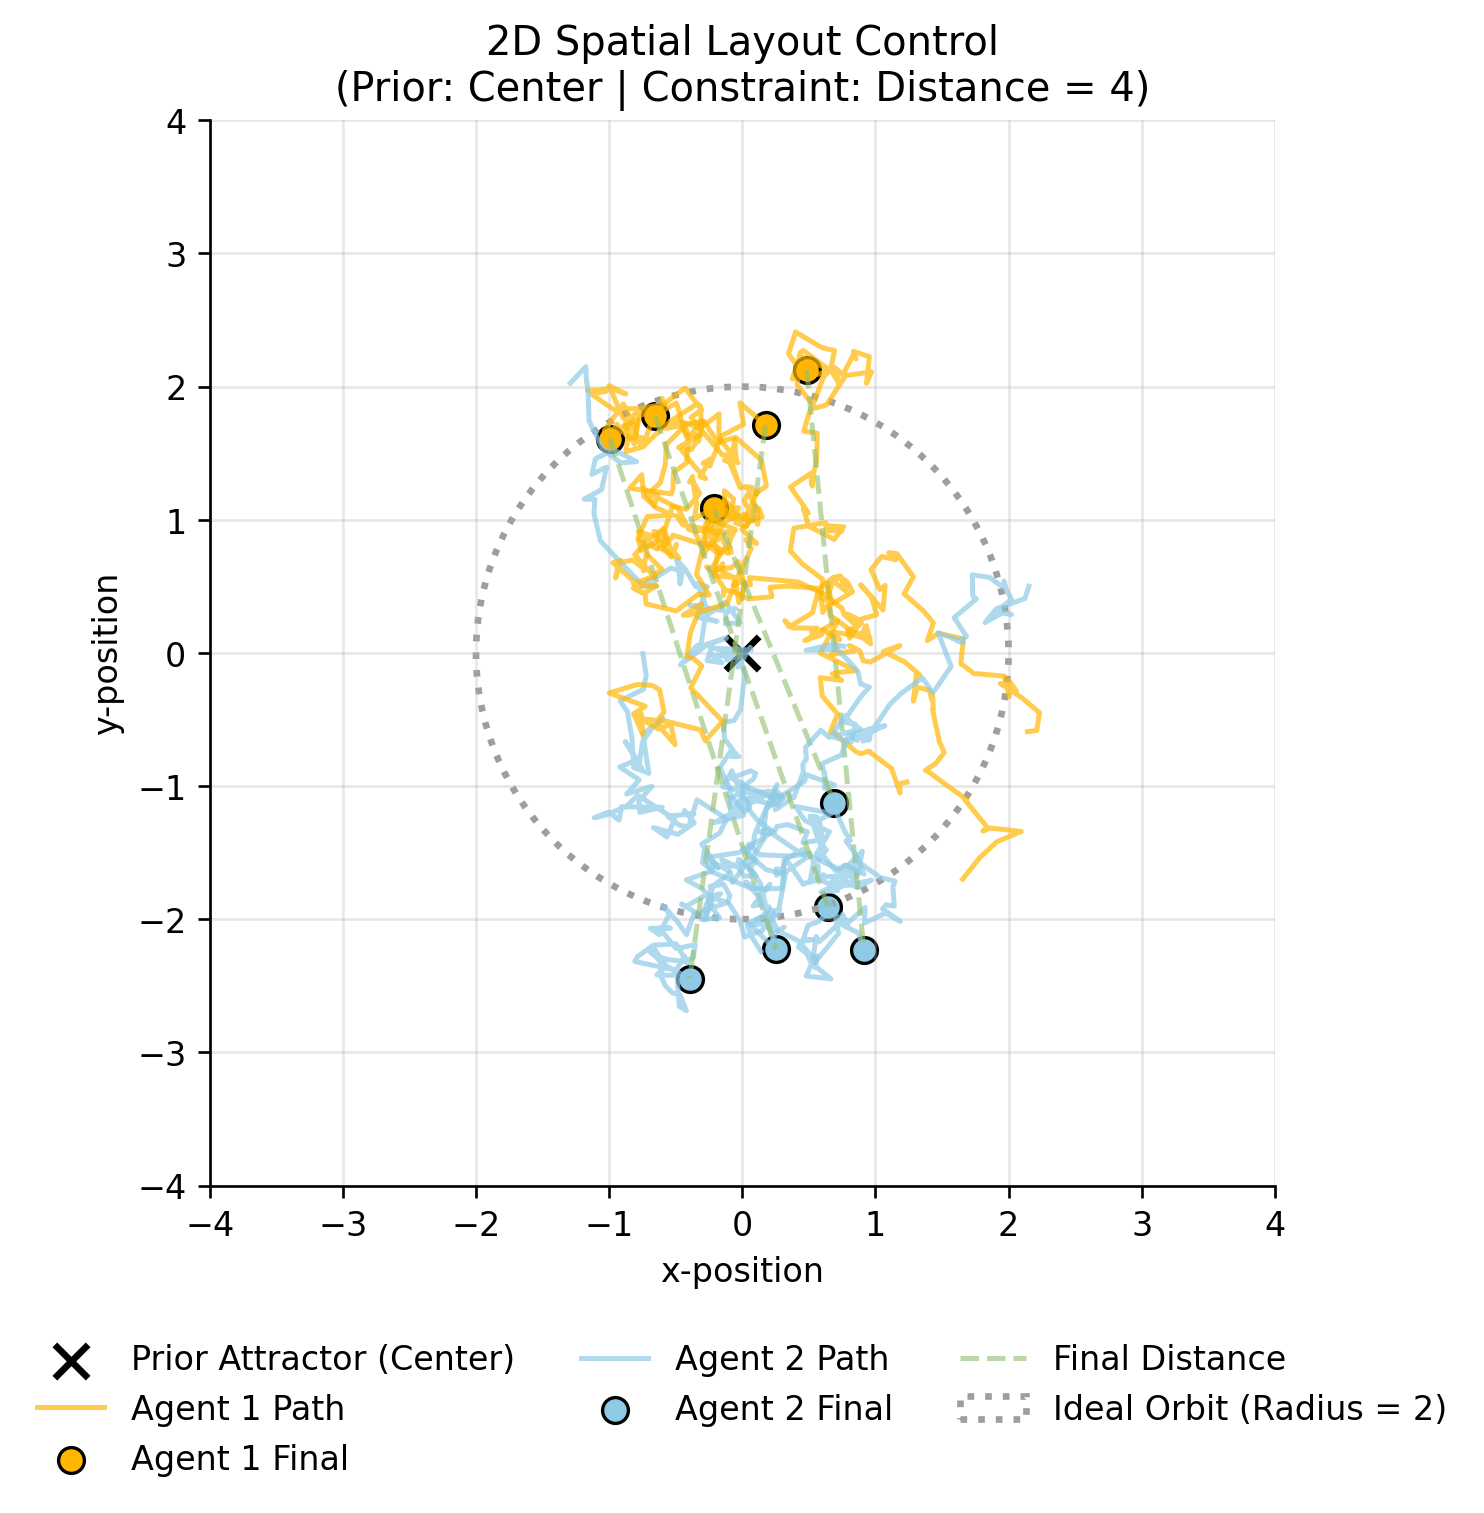

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.set_title("2D Spatial Layout Control\n(Prior: Center | Constraint: Distance = 4)")

# Pastel colors
color_a1 = "#ffb703"  # Agent 1 (orange)
color_a2 = "#8ecae6"  # Agent 2 (blue)
color_conn = "#90be6d"  # soft green for connections
color_ring = "#9e9e9e"  # grey for orbit

center = ax.scatter(0, 0, c="black", marker="x", s=100, linewidths=2)
path1 = path2 = final1 = final2 = conn_line = None

# Trajectories
n_agents = traj_x1.shape[0]
for k in range(n_agents):
    # Agent 1
    p1, = ax.plot(traj_x1[k, :, 0], traj_x1[k, :, 1],
                  c=color_a1, alpha=0.7, linewidth=1.5)
    f1 = ax.scatter(traj_x1[k, -1, 0], traj_x1[k, -1, 1],
                    c=color_a1, edgecolors="black", s=60)

    # Agent 2
    p2, = ax.plot(traj_x2[k, :, 0], traj_x2[k, :, 1],
                  c=color_a2, alpha=0.7, linewidth=1.5)
    f2 = ax.scatter(traj_x2[k, -1, 0], traj_x2[k, -1, 1],
                    c=color_a2, edgecolors="black", s=60)

    # Connection between final positions
    c_line, = ax.plot(
        [traj_x1[k, -1, 0], traj_x2[k, -1, 0]],
        [traj_x1[k, -1, 1], traj_x2[k, -1, 1]],
        c=color_conn, linestyle="--", alpha=0.6, linewidth=1.5
    )

    # save only once for legend
    if k == 0:
        path1, final1, path2, final2, conn_line = p1, f1, p2, f2, c_line

# Target ring (ideal orbit)
circle = plt.Circle((0, 0), 2.0, edgecolor=color_ring,
                    fill=False, linestyle=":", linewidth=2)
ax.add_patch(circle)

# Axes settings
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect("equal", "box")
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")

# Grid & spines
ax.grid(True, alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend at bottom
ax.legend(
    [center, path1, final1, path2, final2, conn_line, circle],
    [
        "Prior Attractor (Center)",
        "Agent 1 Path", "Agent 1 Final",
        "Agent 2 Path", "Agent 2 Final",
        "Final Distance",
        "Ideal Orbit (Radius = 2)",
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()